# Integration of cell lines

## Introduction

If you haven't checked out our basic pipeline, we'd avise starting there as it will explain the different steps in greater detail.

We'll start by loading the single-cell RNA-seq dataset from the CCLE, which contains data on 200 cell lines. This is a very large dataset, so it may take some time to download.

In [1]:
import scycle as cc
import scanpy as sc

sc200 = cc.data.get_data('sc200_CCLE')
sc200

-- Loading data from cache...


AnnData object with n_obs × n_vars = 42362 × 30314
    obs: 'Cell_line', 'Pool_ID', 'Cancer_type', 'Genes_expressed', 'Discrete_cluster_minpts5_eps1.8', 'Discrete_cluster_minpts5_eps1.5', 'Discrete_cluster_minpts5_eps1.2', 'CNA_subclone', 'SkinPig_score', 'EMTI_score', 'EMTII_score', 'EMTIII_score', 'IFNResp_score', 'p53Sen_score', 'EpiSen_score', 'StressResp_score', 'ProtMatu_score', 'ProtDegra_score', 'G1/S_score', 'G2/M_score', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

We'll first apply standard pre-processing using a `scanpy` recipe without pooling to visualize the whole dataset.

In [2]:
cc.pp.filter_cells(sc200)
sc.pp.recipe_zheng17(sc200, n_top_genes = 10000)

34920 cells pass the count filter
42362  cells pass the mt filter
Cells selected 34920


/home/clarice/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.


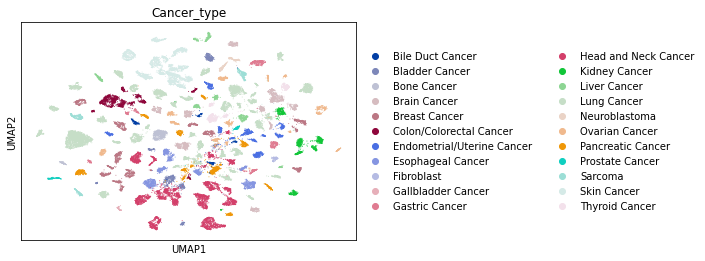

In [3]:
sc.pp.pca(sc200)
sc.pp.neighbors(sc200)
sc.tl.umap(sc200)
sc.pl.umap(sc200, color='Cancer_type')

We can see, as was also described by the publication of these data, that cell lines are quite heterogenous by tissue of origin. We can better inspect it using an interactive plot:

In [5]:
import pandas as pd
import plotly.express as px

sc200_df = pd.DataFrame(sc200.obsm['X_umap'], index = sc200.obs.index, columns = ['x', 'y'])
sc200_df['Cancer_type'] = sc200.obs['Cancer_type'].values
sc200_df['Cell_line'] = sc200.obs['Cell_line'].values
ct_colors = sc200.uns['Cancer_type_colors']

sc200_df = sc200_df.sort_values('Cancer_type')


fig = (px.scatter(sc200_df, x='x', y='y', color ='Cancer_type', 
                  color_discrete_sequence = ct_colors, hover_data=['Cell_line']))
fig.update_traces(marker = dict(size = 2))
fig.update_layout(scene = dict(xaxis_title = 'UMAP1', yaxis_title = 'UMAP2'))
fig

In [6]:
sc200_df.groupby('Cancer_type').count()['x'].sort_values(ascending = False)

Cancer_type
Lung Cancer                   8692
Head and Neck Cancer          4719
Skin Cancer                   2777
Breast Cancer                 2200
Brain Cancer                  2038
Esophageal Cancer             1662
Pancreatic Cancer             1601
Ovarian Cancer                1427
Endometrial/Uterine Cancer    1412
Colon/Colorectal Cancer       1406
Kidney Cancer                 1103
Bladder Cancer                 967
Liver Cancer                   959
Gastric Cancer                 900
Thyroid Cancer                 684
Bone Cancer                    683
Sarcoma                        608
Bile Duct Cancer               353
Neuroblastoma                  263
Prostate Cancer                238
Fibroblast                     147
Gallbladder Cancer              81
Name: x, dtype: int64

In [7]:
sc200_df.reset_index()[['Cancer_type', 'Cell_line']].drop_duplicates().groupby('Cancer_type').count()['Cell_line'].sort_values(ascending = False)

Cancer_type
Lung Cancer                   40
Head and Neck Cancer          19
Skin Cancer                   16
Breast Cancer                 15
Ovarian Cancer                13
Brain Cancer                  12
Pancreatic Cancer             11
Colon/Colorectal Cancer       10
Endometrial/Uterine Cancer    10
Esophageal Cancer              7
Liver Cancer                   7
Gastric Cancer                 6
Bladder Cancer                 6
Kidney Cancer                  6
Bile Duct Cancer               4
Thyroid Cancer                 4
Sarcoma                        3
Bone Cancer                    3
Neuroblastoma                  2
Prostate Cancer                2
Gallbladder Cancer             1
Fibroblast                     1
Name: Cell_line, dtype: int64

The two cancer types with larger representation of cells and cell lines are Lung Cancer and Head and Neck cancer. We'll be subsetting the big dataset to look at cell cycle in the Head and Neck cancer cell lines.

## Head and neck cell line integration

We'll reload and subset the data so we can process using `scycle`.

In [8]:
schn = sc200[sc200.obs['Cancer_type'] == 'Head and Neck Cancer']

We can now look into the cell lines. we see that we have a few cell lines with a low cell count, and that SCC255 and JHU011 have the highest number of cells.

In [9]:
schn.obs.reset_index()[['NAME', 'Cell_line']].groupby('Cell_line').count().sort_values('NAME', ascending = False)['NAME']

Cell_line
SCC25_UPPER_AERODIGESTIVE_TRACT         575
JHU011_UPPER_AERODIGESTIVE_TRACT        541
YD38_UPPER_AERODIGESTIVE_TRACT          426
JHU029_UPPER_AERODIGESTIVE_TRACT        408
93VU_UPPER_AERODIGESTIVE_TRACT          391
SCC9_UPPER_AERODIGESTIVE_TRACT          348
SCC47_UPPER_AERODIGESTIVE_TRACT         332
BICR6_UPPER_AERODIGESTIVE_TRACT         243
BICR31_UPPER_AERODIGESTIVE_TRACT        200
BICR16_UPPER_AERODIGESTIVE_TRACT        175
PECAPJ49_UPPER_AERODIGESTIVE_TRACT      167
SCC90_UPPER_AERODIGESTIVE_TRACT         153
SNU1214_UPPER_AERODIGESTIVE_TRACT       152
JHU006_UPPER_AERODIGESTIVE_TRACT        137
SNU46_UPPER_AERODIGESTIVE_TRACT         126
DETROIT562_UPPER_AERODIGESTIVE_TRACT    117
BHY_UPPER_AERODIGESTIVE_TRACT           110
BICR56_UPPER_AERODIGESTIVE_TRACT         71
SNU899_UPPER_AERODIGESTIVE_TRACT         47
Name: NAME, dtype: int64

We'll follow the initial standard steps of scycle pipeline:

Trying to set attribute `.uns` of view, copying.
/home/clarice/miniconda3/envs/scycle/lib/python3.8/site-packages/scycle/tools/_dimensionality_reduction.py:75: UserWarning:

Data has not been pre-processed using scycle (`pp.prep_pooling`or `pp.prep_simple`), before dimensionality reduction



Dimensionality reduction using PCA...


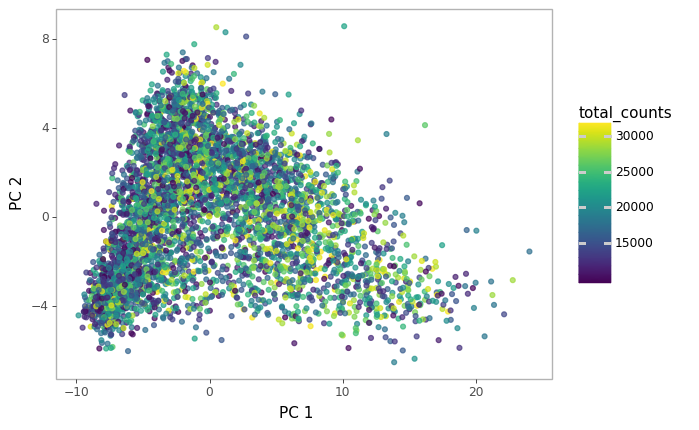

<ggplot: (8781371292889)>

In [10]:
cc.tl.dimensionality_reduction(schn)
cc.pl.cell_cycle_pca(schn)

We can see in the visualization that we don't quite get a "circle" where we can fit a trajectory. We'll dissect this further:

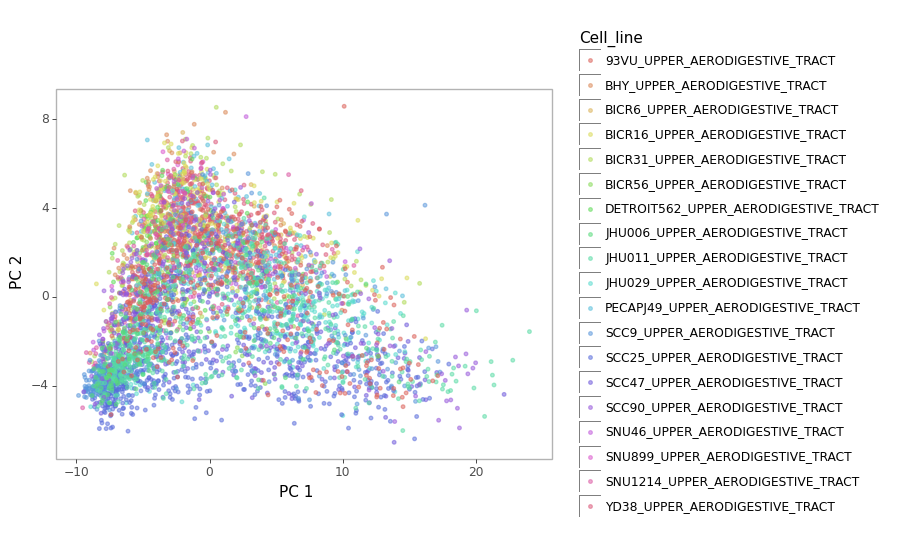

<ggplot: (8781371219914)>

In [11]:
cc.pl.cell_cycle_pca(schn, col_var = 'Cell_line', alpha = 0.5, size = 1)

It seems that cells from the same cell line are following a roughly circular (or 'triangular') trajectory, and we're seeing all their trajectories stacked. Here's an example of single cell lines:

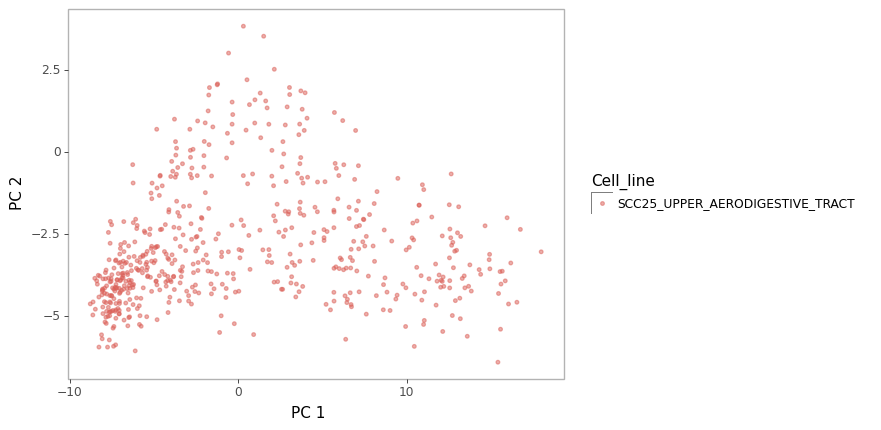

<ggplot: (8781363244029)>

In [12]:
cc.pl.cell_cycle_pca(schn[schn.obs['Cell_line'] == 'SCC25_UPPER_AERODIGESTIVE_TRACT'], col_var = 'Cell_line', alpha = 0.5, size = 1)

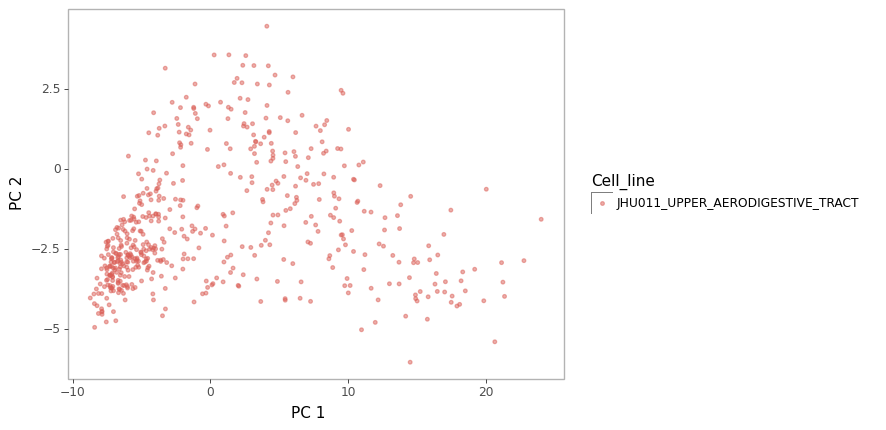

<ggplot: (8781370340241)>

In [13]:
cc.pl.cell_cycle_pca(schn[schn.obs['Cell_line'] == 'JHU011_UPPER_AERODIGESTIVE_TRACT'], col_var = 'Cell_line', alpha = 0.5, size = 1)

As JHU011 had a cleaner trajectory, we'll use it as the reference for integration. In `scycle`, integration is implemented using weighted optimal transport (WOTi):

In [14]:
jhu011 = schn[schn.obs['Cell_line'] == 'JHU011_UPPER_AERODIGESTIVE_TRACT']

In [15]:
cc.tl.integration(schn, jhu011)

AttributeError: 'PCA' object has no attribute 'S_'

We can inspect the results of the integration below:

In [15]:
cc.pl.cell_cycle_pca3d(schn, col_var = 'Cell_line', alpha = 0.5, size = 1.5)

Now we can proceed with the analysis of all the head and neck cell lines.

## Run scycle on integrated dataset

Now we can simply follow the pipeline:
1. cc.tl.trajectory finds the circular trajectory
2. cc.tl.cell_division cuts the trajectory by finding the moment of cell division based on total_counts
3. cc.tl.pseudotime calculates a pseudotime between 0 and 1 based on the trajectory
4. cc.tl.cell_cycle_phase assigns a cell cycle phase to each cell based on their pseudotime and on the curvature of the trajectory in the embedded space

In [16]:
cc.tl.trajectory(schn)

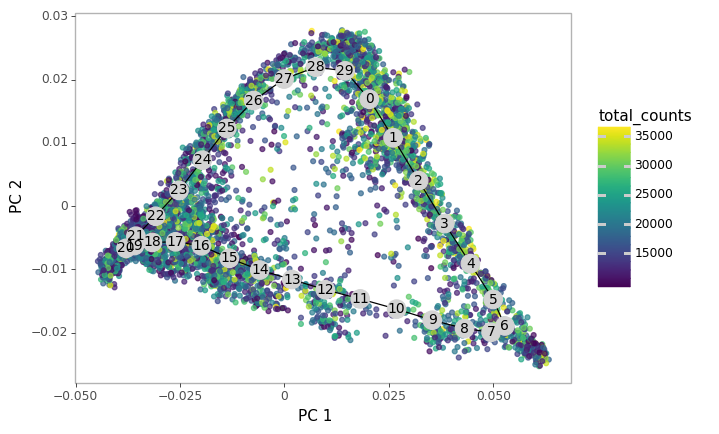

<ggplot: (8756503093932)>

In [17]:
cc.pl.cell_cycle_pca(schn, trajectory = True)

In [29]:
cc.tl.cell_division(schn)

Suggested moment of cell division: [4 5]
Direction of cell cycle: 1
Remapping edges using [4 5] ...


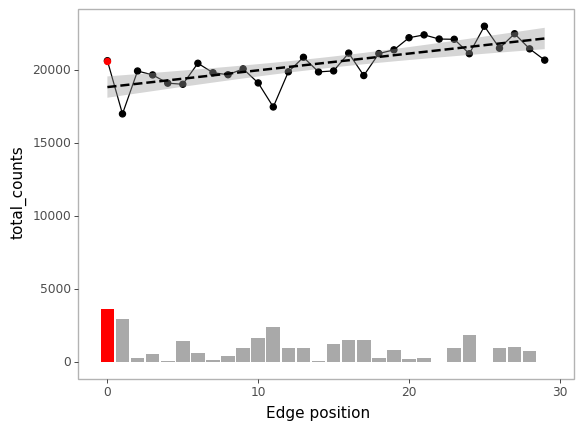

<ggplot: (8756511319372)>

In [30]:
cc.pl.cell_division(schn)

In [31]:
cc.tl.pseudotime(schn)

Calculating pseudotimes for each cell...


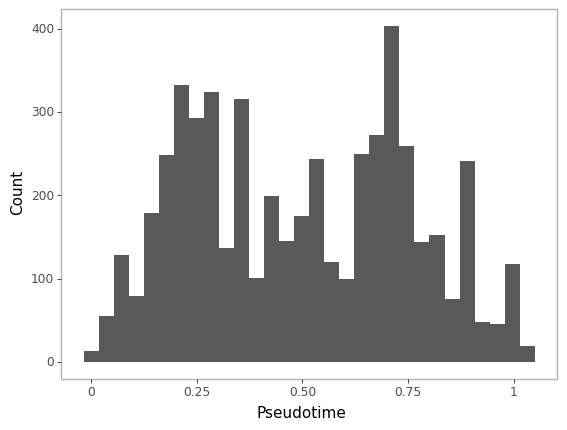

<ggplot: (8756494910850)>

In [32]:
cc.pl.pseudotime_histogram(schn)

In [33]:
cc.tl.cell_cycle_phase(schn)

-- Suggested cell cycle division:
G1:  0   - 0.3333333333333333
S:  0.3333333333333333 - 0.6666666666666666
G2-M: 0.6666666666666666 - 1


/home/clarice/.local/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning:

geom_vline : Removed 1 rows containing missing values.



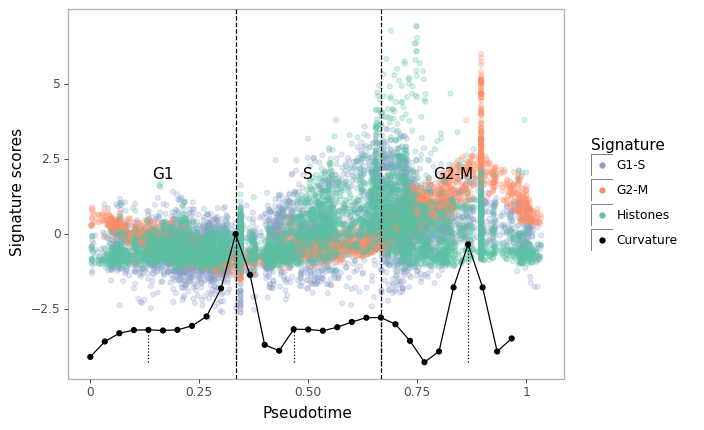

<ggplot: (8756600572353)>

In [34]:
cc.pl.cell_cycle_scores(schn, alpha = 0.25)

([<matplotlib.patches.Wedge at 0x7f6c84029970>,
 [Text(0.5811813489928175, 0.9923347416990342, 'G2-M'),
  Text(-1.149458539442629, 0.03528549422096812, 'S'),
  Text(0.5504598632792116, -1.0096999251850185, 'G1')],
 [Text(0.2779562973443909, 0.47459487646475546, '33.1%'),
  Text(-0.5497410406029966, 0.016875671149158666, '32.8%'),
  Text(0.2632634128726664, -0.48289996421892184, '34.1%')])

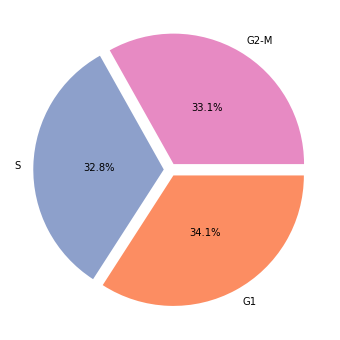

In [35]:
cc.pl.cell_cycle_phase_pieplot(schn)

## Inspect results

Now that the pipeline is complete, the results generated using `scycle` can also be easily accessed by scanpy and used in relation to other variables. Here, we'll simply plot them in the UMAP projection.

In [36]:
sc.pp.pca(schn)
sc.pp.neighbors(schn)
sc.tl.umap(schn)

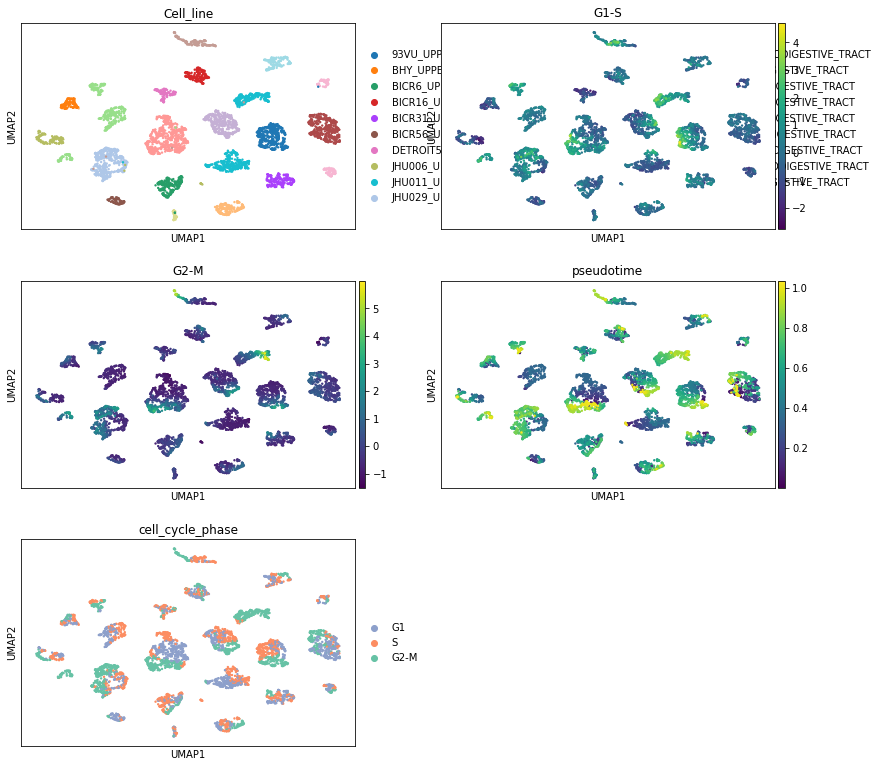

In [37]:
schn.uns['cell_cycle_phase_colors'] = ['#8da0cb', '#fc8d62', '#66c2a5']
sc.pl.umap(schn, color = ['Cell_line', 'G1-S', 'G2-M', 'pseudotime', 'cell_cycle_phase'], ncols = 2)